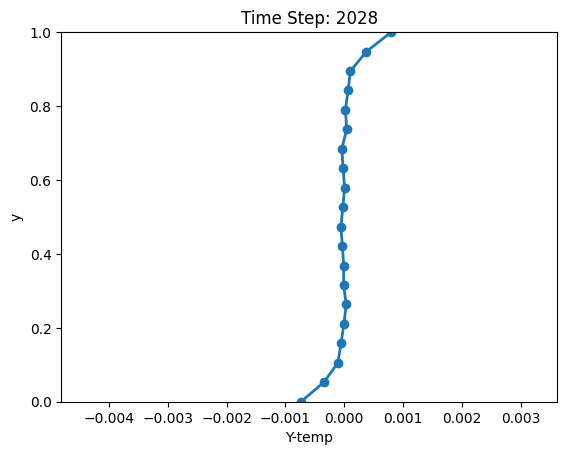

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter


# Load data
vprof_data = np.loadtxt("/home/muhammed/Documents/Thesis/Shear_Simulation_Results/Run_shear_Newton/80/vprof.txt")  # shape: (ntimesteps, nx_meas)
nx_meas = vprof_data.shape[1]
n_total_steps = vprof_data.shape[0]

# LIMIT frames — pick only 300 evenly spaced steps
n_max_frames = 1000
total_steps = vprof_data.shape[0]
stride = max(1, total_steps // n_max_frames)
vprof_data = vprof_data[::stride, :]  # downsample

# Recompute frame count
n_frames = vprof_data.shape[0]

# Spatial domain
x = np.linspace(0, 1, nx_meas)  # or use actual physical bin locations if available

# Precompute plot limits
ymin, ymax = np.min(vprof_data), np.max(vprof_data)

# Setup figure
fig, ax = plt.subplots()
line, = ax.plot([], [], 'o-', lw=2)
ax.set_xlim(ymin-(ymax/4), ymax)
ax.set_ylim(x[0], x[-1])
ax.set_xlabel("Y-temp")
ax.set_ylabel("y")
ax.set_title("Shear Velocity Profile Evolution")

# Initialization function
def init():
    line.set_data([], [])
    return line,

# Animation update function
def update(frame):
    y = vprof_data[frame]
    line.set_data(y, x)
    ax.set_title(f"Time Step: {frame * stride}")
    return line,

# Animate and save as lightweight GIF
ani = FuncAnimation(fig, update, frames=n_frames, init_func=init,
                    blit=True, interval=50)  # faster playback (50ms/frame)

ani.save("/home/muhammed/Documents/Thesis/Shear_Simulation_Results/Run_shear_Newton/v_profile.gif", writer=PillowWriter(fps=10))  # GIF!


In [70]:
!pip install mpl_toolkits

ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for mpl_toolkits


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import math
from matplotlib import ticker
from colormap import rgb2hex                         # keep if you prefer it
# NEW ────────────────────────────────────────────────────────────────────────
# axes_grid → axes_grid1   (same functionality, maintained sub-package)
from mpl_toolkits.axes_grid1.inset_locator import (
    inset_axes, InsetPosition, mark_inset
)
# ────────────────────────────────────────────────────────────────────────────

# --------------------------------------------------------------------------
# Matplotlib global style
# --------------------------------------------------------------------------
plt.rc("text", usetex=False)
plt.rc("font", size=12)
plt.rc("axes", titlesize=60)
plt.rcParams.update({
    "legend.fontsize": 12,
    "lines.markersize": 5,
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.2,
    "lines.linewidth": 1.0,
})

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
formatter.set_powerlimits((-1, 1))

# --------------------------------------------------------------------------
# Plot parameters
# --------------------------------------------------------------------------
aspect = 1.0

# Custom colour palette (red → blue gradient)
ncol = 5
red  = np.array([254,   0,   2], dtype=int)
blue = np.array([  3,   2, 252], dtype=int)

c1 = np.linspace(red[0],  blue[0],  ncol, dtype=int)
c2 = np.linspace(red[1],  blue[1],  ncol, dtype=int)
c3 = np.linspace(red[2],  blue[2],  ncol, dtype=int)

colors = [rgb2hex(r, g, b) for r, g, b in zip(c1, c2, c3)][::-1]

markers = ["o", "^", "v", "s", "D", "X", "*"]

In [8]:
markers

['o', '^', 'v', 's', 'D', 'X', '*']

In [9]:
def loadtxt_fortran(filename):
    with open(filename, 'r') as f:
        content = f.read().replace('D', 'E')
    from io import StringIO
    return np.loadtxt(StringIO(content))

In [10]:
def beta_0(alpha):
    return ((1+alpha)/2)*(1-((1-alpha)/3))

def zeta_0(alpha):
    return (1-alpha**2)*(5/12)

def a_steady(beta, zeta):
    return (np.sqrt((3*zeta)/(2*beta)))*(beta+zeta)

In [11]:
def detect_plateau(tg, window=100, threshold=1e-3):
    rel_change = np.abs(np.diff(tg) / tg[:-1])
    idx = np.where(rel_change < threshold)[0]

    # Find longest consecutive plateau
    from itertools import groupby
    from operator import itemgetter
    groups = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(idx), lambda ix: ix[0]-ix[1])]
    if not groups:
        raise RuntimeError("No steady state detected.")
    plateau = max(groups, key=len)
    
    if len(plateau) < window:
        print("Warning: short steady region found.")
    
    return plateau[0], plateau[-1]


In [12]:
# Chi function (Ma and Ahmadi)
def chi_ma(sol_frac):
    sol_frac_pack = 0.643
    C1, C2, C3, C_POW = 2.5, 4.5904, 4.515439, 0.67802
    if sol_frac > sol_frac_pack:
        return 1000.0
    numer = 1.0 + C1 * sol_frac + C2 * sol_frac**2 + C3 * sol_frac**3
    numer = numer * 4.0 * sol_frac
    denom = (1.0 - (sol_frac/sol_frac_pack)**3.0)**C_POW
    chi = 1.0 + numer/denom
    return min(chi, 1000.0)

def chi_Carnahan_Starling(solfrac):
    return (1 - solfrac/2)/((1-solfrac)**3)

L = 0.1
sigma = 0.01
sol_frac = 0.01
n = (6.0 * sol_frac) / (np.pi * sigma**3)

chi_val = chi_ma(sol_frac)
chi_val

1.04101864683189

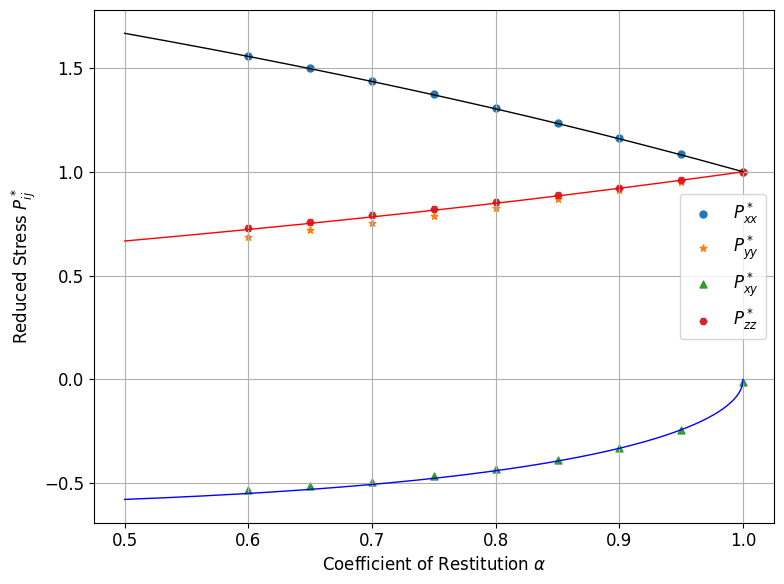

In [22]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Paths
base_dir = '/home/muhammed/Documents/Thesis/Shear_Simulation_Results/Run_shear_NN'
alpha_dirs = ['60', '65', '70', '75', '80', '85', '90', '95', '100']  # Skip '100'

# Simulation constants
n_particles = 100000  # Adjust if needed
volume = 0.1**3       # Assuming your domain is 0.1x0.1x0.1
density = n_particles / volume

# Functions
#def find_steady_state(tg):
#    """Find steady state by thresholding the derivative."""
#    rel_change = np.abs(np.diff(tg) / tg[:-1])
#    threshold = 1e-3
#    steady_indices = np.where(rel_change < threshold)[0]
#    if len(steady_indices) == 0:
#        raise RuntimeError('No steady state found.')
#    start_idx = steady_indices[0]
#    return start_idx

# Store results
alpha_vals = []
Pxx_vals = []
Pyy_vals = []
Pxy_vals = []
Pzz_vals = []

for folder in alpha_dirs:
    folder_path = os.path.join(base_dir, folder)
    
    # Load data
    tg = np.loadtxt(os.path.join(folder_path, 'tg.txt'))[:,2]  # Assuming format: time, Tg
    pijk = loadtxt_fortran(os.path.join(folder_path, 'Pijk.txt'))
    pijc = loadtxt_fortran(os.path.join(folder_path, 'Pijc.txt'))

    # Sum kinetic + collisional
    Pxx = pijk[1:,0] + pijc[:,0]
    Pyy = pijk[1:,1] + pijc[:,3]
    Pxy = pijk[1:,3] + pijc[:,1]
    Pzz = pijk[1:,2] + pijc[:,5]

    # Find steady state
    steady_start, steady_end = detect_plateau(tg)
    
    # Average over steady state window
    Pxx_mean = np.mean(Pxx[-500:])
    Pyy_mean = np.mean(Pyy[-500:])
    Pxy_mean = np.mean(Pxy[-500:])
    Pzz_mean = np.mean(Pzz[-500:])
    Tg_mean  = np.mean(tg[-500:])
    
    # Compute reduced stresses
    Pxx_star = Pxx_mean / (density * Tg_mean*chi_val)
    Pyy_star = Pyy_mean / (density * Tg_mean*chi_val)
    Pzz_star = Pzz_mean / (density * Tg_mean*chi_val)
    Pxy_star = Pxy_mean / (density * Tg_mean*chi_val)

    # Store
    alpha = int(folder) / 100.0
    alpha_vals.append(alpha)
    Pxx_vals.append(Pxx_star)
    Pyy_vals.append(Pyy_star)
    Pxy_vals.append(Pxy_star)
    Pzz_vals.append(Pzz_star)

# Convert to arrays
alpha_vals = np.array(alpha_vals)
Pxx_vals = np.array(Pxx_vals)
Pyy_vals = np.array(Pyy_vals)
Pxy_vals = np.array(Pxy_vals)
Pzz_vals = np.array(Pzz_vals)

alphas = np.linspace(0.5, 1, 1000)
betas = beta_0(alphas)
zetas = zeta_0(alphas)
Pxx_KT = (betas + 3*zetas)/(betas + zetas)
Pyy_KT = betas/(betas+zetas)
Pxy_KT = -(betas/((betas+zetas)**2)) * a_steady(betas, zetas)


# Plotting
plt.figure(figsize=(8,6))
plt.scatter(alpha_vals, Pyy_vals*1000, marker='o', label=r'$P_{xx}^*$')
plt.plot(alphas, Pyy_KT, '-r')
plt.scatter(alpha_vals, Pxx_vals*1000, marker='*', label=r'$P_{yy}^*$')
plt.plot(alphas, Pxx_KT, '-k')
plt.scatter(alpha_vals, Pxy_vals*1000, marker='^', label=r'$P_{xy}^*$')
plt.plot(alphas, Pxy_KT, '-b')

plt.scatter(alpha_vals, Pzz_vals*1000, marker='H', label=r'$P_{zz}^*$')
plt.xlabel(r'Coefficient of Restitution $\alpha$')
plt.ylabel(r'Reduced Stress $P_{ij}^*$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


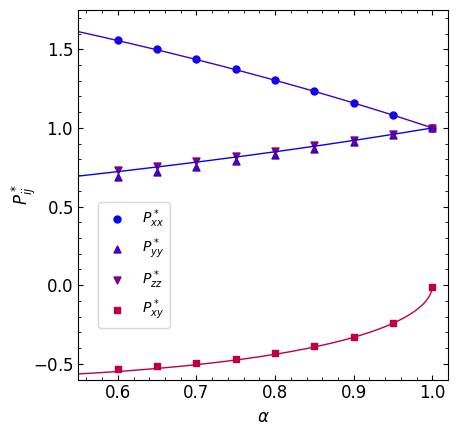

In [23]:
# log (alpha=0.9)
fig,ax = plt.subplots();
ax.yaxis.set_major_formatter(formatter)

ax.scatter(alpha_vals, Pyy_vals*1000, label=r'$P_{xx}^*$', marker=markers[0], color=colors[0])
ax.scatter(alpha_vals, Pxx_vals*1000, label=r'$P_{yy}^*$', marker=markers[1], color=colors[1])
ax.scatter(alpha_vals, Pzz_vals*1000, label=r'$P_{zz}^*$', marker=markers[2], color=colors[2])
ax.scatter(alpha_vals, Pxy_vals*1000, label=r'$P_{xy}^*$', marker=markers[3], color=colors[3])

ax.plot(alphas, Pyy_KT, '-', color=colors[0])
ax.plot(alphas, Pxx_KT, '-', color=colors[1])
ax.plot(alphas, Pxy_KT, '-', color=colors[3])

ax.set_xlim([0.55,1.02])
ax.set_ylim([-0.6,1.75])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$P_{ij}^*$',labelpad=-4)
xval, yval = ax.get_xlim(), ax.get_ylim()
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')

ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)
ax.minorticks_on()
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.15, 0.5),  # X, Y: lower values shift it down
    fontsize=10,
    frameon=True
)

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.savefig('ScaledTClasslog09.eps',bbox_inches='tight')

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

# ------------------------------------------------------------
# Formatting (reuse your existing style if already imported)
# ------------------------------------------------------------
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
formatter.set_powerlimits((-1, 1))

# ------------------------------------------------------------
# Physical parameters (must match simulation)
# ------------------------------------------------------------
L = 0.0286
B = 0.0143
sigma = 0.0004762
sol_frac = 0.01

n = (6.0 * sol_frac) / (np.pi * sigma**3)
volume = L**2 * B
density = n   # number density

def chi_ma(sol_frac):
    sol_frac_pack = 0.643
    C1, C2, C3, C_POW = 2.5, 4.5904, 4.515439, 0.67802
    if sol_frac > sol_frac_pack:
        return 1000.0
    numer = 1.0 + C1 * sol_frac + C2 * sol_frac**2 + C3 * sol_frac**3
    numer = numer * 4.0 * sol_frac
    denom = (1.0 - (sol_frac/sol_frac_pack)**3.0)**C_POW
    return min(1.0 + numer/denom, 1000.0)

chi_val = chi_ma(sol_frac)

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
base_dir = "/home/muhammed/Documents/Thesis/Shear_Simulation_Results/DEM/Validations/dilute_vary_alpha"
alpha_dirs = ["60","65","70","75","80","85","90","95","100"]

# ------------------------------------------------------------
# Storage
# ------------------------------------------------------------
alpha_vals1 = []
Pxx_vals1 = []
Pyy_vals1 = []
Pzz_vals1 = []
Pxy_vals1 = []

# ------------------------------------------------------------
# Loop over alpha folders
# ------------------------------------------------------------
for folder in alpha_dirs:
    folder_path = os.path.join(base_dir, folder)
    stress_file = os.path.join(folder_path, "stress.txt")
    T_file = os.path.join(folder_path, "T.txt")

    stress = np.loadtxt(stress_file)
    Tdata  = np.loadtxt(T_file)

    time = stress[:,0]
    Pxx = stress[:,1]
    Pxy = stress[:,3]
    Pyy = stress[:,5]
    Pzz = stress[:,9]

    Tg = Tdata[:,2]  # translational granular temperature

    # --- Steady averaging window ---
    # Take last 20% of samples (robust for DEM)
    N = len(time)
    i0 = int(0.6 * N)

    Pxx_m = np.mean(Pxx[i0:])
    Pyy_m = np.mean(Pyy[i0:])
    Pzz_m = np.mean(Pzz[i0:])
    Pxy_m = np.mean(Pxy[i0:])
    Tg_m  = np.mean(Tg[i0:])

    # Reduced stresses
    Pxx_star = Pxx_m / (density * Tg_m*chi_val)
    Pyy_star = Pyy_m / (density * Tg_m*chi_val)
    Pzz_star = Pzz_m / (density * Tg_m)
    Pxy_star = Pxy_m / (density * Tg_m*chi_val)

    alpha_vals1.append(int(folder)/100)
    Pxx_vals1.append(Pxx_star)
    Pyy_vals1.append(Pyy_star)
    Pzz_vals1.append(Pzz_star)
    Pxy_vals1.append(Pxy_star)

# Convert to arrays
alpha_vals1 = np.array(alpha_vals)
Pxx_vals1 = np.array(Pxx_vals1)
Pyy_vals1 = np.array(Pyy_vals1)
Pzz_vals1 = np.array(Pzz_vals1)
Pxy_vals1 = np.array(Pxy_vals1)


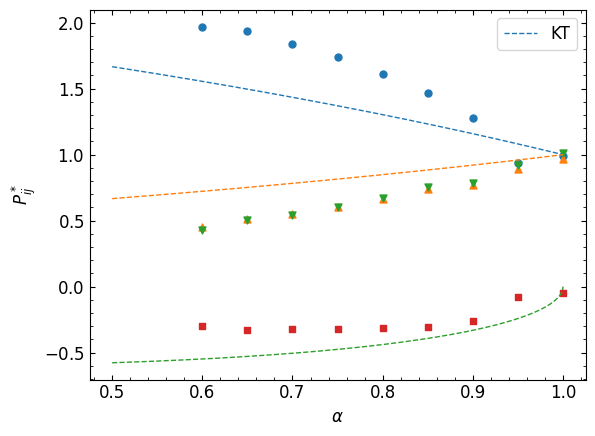

In [26]:
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)

ax.scatter(alpha_vals1, Pxx_vals1, marker="o")
ax.scatter(alpha_vals1, Pyy_vals1, marker="^")
ax.scatter(alpha_vals1, Pzz_vals1, marker="v")
ax.scatter(alpha_vals1, Pxy_vals1, marker="s")

ax.plot(alphas, Pxx_KT, "--", label="KT")
ax.plot(alphas, Pyy_KT, "--")
ax.plot(alphas, Pxy_KT, "--")

#ax.set_xlim(0.55,1.02)
#ax.set_ylim(-0.6,1.75)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$P_{ij}^*$")

ax.tick_params(direction="in", which="both", top=True, right=True)
ax.minorticks_on()
ax.legend()

plt.show()

Selected windows (t0, t1) per alpha:
alpha=0.60 : 0.4629 to 0.7002
alpha=0.65 : 0.4654 to 0.6863
alpha=0.70 : 0.4699 to 0.6726
alpha=0.75 : 0.4712 to 0.6549
alpha=0.80 : 0.4795 to 0.6390
alpha=0.85 : 0.4502 to 0.5682
alpha=0.90 : 0.4957 to 0.6031
alpha=0.95 : 0.5164 to 0.6139
alpha=1.00 : 0.6702 to 0.7462


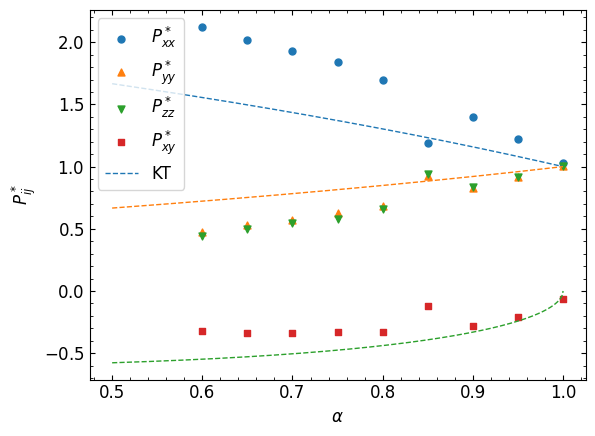

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
formatter.set_powerlimits((-1, 1))

# -----------------------------
# Physical parameters
# -----------------------------
sigma = 4.762e-4
sol_frac = 0.01
n = (6.0 * sol_frac) / (np.pi * sigma**3)   # number density

# -----------------------------
# Helper: moving linear slope
# -----------------------------
def moving_slope(t, y, w):
    """
    Return slope dy/dt estimated by local linear regression in a window of w points.
    slope[i] corresponds to center of window; endpoints filled with nan.
    """
    N = len(t)
    s = np.full(N, np.nan)
    half = w // 2
    for i in range(half, N-half):
        tt = t[i-half:i+half+1]
        yy = y[i-half:i+half+1]
        # linear regression slope
        A = np.vstack([tt - tt.mean(), np.ones_like(tt)]).T
        m, _ = np.linalg.lstsq(A, yy, rcond=None)[0]
        s[i] = m
    return s

def select_usf_window(time, Tg, Pxy,
                      w_slope=51,
                      w_win=200,
                      eps_logT=2e-3,
                      eps_relP=2e-3,
                      cvT_max=0.05,
                      cvP_max=0.15,
                      min_start_frac=0.1,
                      max_end_frac=0.95):
    """
    Select a quasi-steady homogeneous USF window for DEM.

    Criteria:
      - small drift: |d ln(T)/dt| < eps_logT
      - small drift: |d Pxy/dt| / |Pxy| < eps_relP
      - low variability: std(T)/mean(T) < cvT_max, std(Pxy)/|mean(Pxy)| < cvP_max
    """
    t = time
    N = len(t)

    # guard
    if N < max(w_slope, w_win) + 10:
        return int(0.6*N), N-1  # fallback

    # compute slopes
    logT = np.log(np.clip(Tg, 1e-30, None))
    dlogTdt = moving_slope(t, logT, w_slope)

    dPdt = moving_slope(t, Pxy, w_slope)
    rel_dPdt = np.abs(dPdt) / np.clip(np.abs(Pxy), 1e-30, None)

    good = (np.abs(dlogTdt) < eps_logT) & (rel_dPdt < eps_relP)

    # only allow a reasonable region (avoid very early transient, very late blow-up)
    i_min = int(min_start_frac * N)
    i_max = int(max_end_frac * N)
    good[:i_min] = False
    good[i_max:] = False

    # scan windows and score them
    best = None
    best_score = np.inf
    for i0 in range(i_min, i_max - w_win):
        i1 = i0 + w_win
        if not np.all(good[i0:i1]):
            continue

        Tg_w = Tg[i0:i1]
        Pxy_w = Pxy[i0:i1]

        Tg_m = Tg_w.mean()
        Pxy_m = Pxy_w.mean()

        # coefficients of variation
        cvT = Tg_w.std(ddof=1) / np.clip(Tg_m, 1e-30, None)
        cvP = Pxy_w.std(ddof=1) / np.clip(np.abs(Pxy_m), 1e-30, None)

        if (cvT > cvT_max) or (cvP > cvP_max):
            continue

        # stationarity score: drift + variability (smaller is better)
        score = (np.nanmean(np.abs(dlogTdt[i0:i1])) / eps_logT
                 + np.nanmean(rel_dPdt[i0:i1]) / eps_relP
                 + 2.0*cvT/cvT_max
                 + 1.0*cvP/cvP_max)

        if score < best_score:
            best_score = score
            best = (i0, i1-1)

    if best is None:
        # fallback: choose the “least drifting” late-mid window (not last tail)
        i0 = int(0.5*N)
        i1 = min(N-1, i0 + w_win)
        return i0, i1
    return best

# -----------------------------
# Main loop: compute reduced stresses
# -----------------------------
base_dir = "/home/muhammed/Documents/Thesis/Shear_Simulation_Results/DEM/Validations/nu_001"
alpha_dirs = ["60","65","70","75","80","85","90","95","100"]

alpha_vals2 = []
Pxx_vals2 = []
Pyy_vals2 = []
Pzz_vals2 = []
Pxy_vals2 = []

# OPTIONAL: store window info for debugging/plotting
windows = {}

for folder in alpha_dirs:
    folder_path = os.path.join(base_dir, folder)
    stress = np.loadtxt(os.path.join(folder_path, "stress.txt"))
    Tdata  = np.loadtxt(os.path.join(folder_path, "T.txt"))

    # align by time (stress and T may be written at same cadence, but safer to interpolate)
    tS = stress[:,0]
    tT = Tdata[:,0]

    # stresses from your write:
    PxxS = stress[:,1]
    PxyS = stress[:,3]
    PyyS = stress[:,5]
    PzzS = stress[:,9]

    TgT  = Tdata[:,2]  # translational granular temperature (your definition)

    # interpolate Tg onto stress time grid
    Tg = np.interp(tS, tT, TgT)

    # pick window
    i0, i1 = select_usf_window(tS, Tg, PxyS,
                              w_slope=51,
                              w_win=max(200, len(tS)//10),
                              eps_logT=3e-3,
                              eps_relP=3e-3,
                              cvT_max=0.06,
                              cvP_max=0.20,
                              min_start_frac=0.15,
                              max_end_frac=0.90)

    windows[folder] = (tS[i0], tS[i1])

    # average over window
    Pxx_m = PxxS[i0:i1+1].mean()
    Pyy_m = PyyS[i0:i1+1].mean()
    Pzz_m = PzzS[i0:i1+1].mean()
    Pxy_m = PxyS[i0:i1+1].mean()
    Tg_m  = Tg[i0:i1+1].mean()

    # dilute reduced stresses (no chi)
    Pxx_star = Pxx_m / (n * Tg_m)
    Pyy_star = Pyy_m / (n * Tg_m)
    Pzz_star = Pzz_m / (n * Tg_m)
    Pxy_star = Pxy_m / (n * Tg_m)

    alpha_vals2.append(int(folder)/100)
    Pxx_vals2.append(Pxx_star)
    Pyy_vals2.append(Pyy_star)
    Pzz_vals2.append(Pzz_star)
    Pxy_vals2.append(Pxy_star)

alpha_vals2 = np.array(alpha_vals2)
Pxx_vals2 = np.array(Pxx_vals2)
Pyy_vals2 = np.array(Pyy_vals2)
Pzz_vals2 = np.array(Pzz_vals2)
Pxy_vals2 = np.array(Pxy_vals2)

print("Selected windows (t0, t1) per alpha:")
for f in alpha_dirs:
    print(f"alpha={int(f)/100:.2f} : {windows[f][0]:.4f} to {windows[f][1]:.4f}")

# -----------------------------
# Plot (DEM points only here)
# -----------------------------
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)

ax.scatter(alpha_vals2, Pxx_vals2, label=r"$P_{xx}^*$", marker="o")
ax.scatter(alpha_vals2, Pyy_vals2, label=r"$P_{yy}^*$", marker="^")
ax.scatter(alpha_vals2, Pzz_vals2, label=r"$P_{zz}^*$", marker="v")
ax.scatter(alpha_vals2, Pxy_vals2, label=r"$P_{xy}^*$", marker="s")

ax.plot(alphas, Pxx_KT, "--", label="KT")
ax.plot(alphas, Pyy_KT, "--")
ax.plot(alphas, Pxy_KT, "--")

ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$P_{ij}^*$")
ax.tick_params(direction="in", which="both", top=True, right=True)
ax.minorticks_on()
ax.legend()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


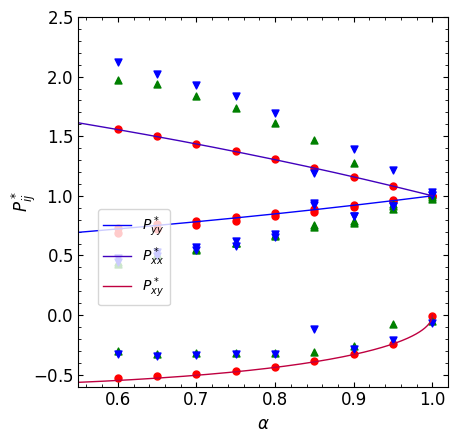

In [30]:
# log (alpha=0.9)
fig,ax = plt.subplots();
ax.yaxis.set_major_formatter(formatter)

# DSMC
ax.scatter(alpha_vals, Pyy_vals*1000, marker=markers[0], color='red')
ax.scatter(alpha_vals, Pxx_vals*1000, marker=markers[0], color='red')
ax.scatter(alpha_vals, Pzz_vals*1000, marker=markers[0], color='red')
ax.scatter(alpha_vals, Pxy_vals*1000, marker=markers[0], color='red')

# DEM1
ax.scatter(alpha_vals1, Pxx_vals1,  marker=markers[1], color='green')
ax.scatter(alpha_vals1, Pyy_vals1,  marker=markers[1], color='green')
ax.scatter(alpha_vals1, Pzz_vals1,  marker=markers[1], color='green')
ax.scatter(alpha_vals1, Pxy_vals1,  marker=markers[1], color='green')

# DEM2
ax.scatter(alpha_vals2, Pxx_vals2,  marker=markers[2], color='blue')
ax.scatter(alpha_vals2, Pyy_vals2,  marker=markers[2], color='blue')
ax.scatter(alpha_vals2, Pzz_vals2,  marker=markers[2], color='blue')
ax.scatter(alpha_vals2, Pxy_vals2,  marker=markers[2], color='blue')

ax.plot(alphas, Pyy_KT, '-', color=colors[0], label=r'$P_{yy}^*$')
ax.plot(alphas, Pxx_KT, '-', color=colors[1], label=r'$P_{xx}^*$')
ax.plot(alphas, Pxy_KT, '-', color=colors[3], label=r'$P_{xy}^*$')

ax.set_xlim([0.55,1.02])
ax.set_ylim([-0.6,2.5])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$P_{ij}^*$',labelpad=-4)
xval, yval = ax.get_xlim(), ax.get_ylim()
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')

ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)
ax.minorticks_on()
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.15, 0.5),  # X, Y: lower values shift it down
    fontsize=10,
    frameon=True
)

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.savefig('ScaledTClasslog09.eps',bbox_inches='tight')

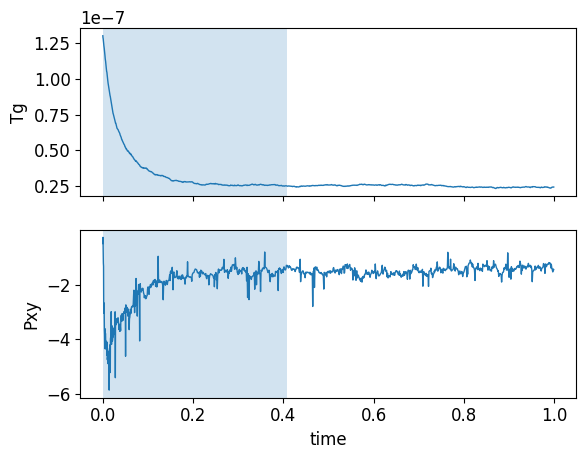

In [90]:
def debug_timeseries(folder_path, i0, i1):
    stress = np.loadtxt(os.path.join(folder_path, "stress.txt"))
    Tdata  = np.loadtxt(os.path.join(folder_path, "T.txt"))

    tS = stress[:,0]
    Pxy = stress[:,3]
    tT = Tdata[:,0]
    TgT = Tdata[:,2]
    Tg = np.interp(tS, tT, TgT)

    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].plot(tS, Tg)
    ax[0].axvspan(tS[i0], tS[i1], alpha=0.2)
    ax[0].set_ylabel("Tg")

    ax[1].plot(tS, Pxy)
    ax[1].axvspan(tS[i0], tS[i1], alpha=0.2)
    ax[1].set_ylabel("Pxy")
    ax[1].set_xlabel("time")
    plt.show()

base_dir = "/home/muhammed/Documents/Thesis/Shear_Simulation_Results/DEM/Validations/dilute_vary_alpha/70"
debug_timeseries(base_dir, 0, 500)

In [62]:
def load_vx_profile(filename, zlength, discard=2):
    """
    discard = number of bins to remove from each boundary
    """
    data = np.loadtxt(filename)

    time = data[:,0]
    vx   = data[:,1:]

    NBIN = vx.shape[1]
    dz = zlength / NBIN
    z = (np.arange(NBIN) + 0.5) * dz

    # steady averaging
    i0 = int(0.8 * len(time))
    vx_mean = np.mean(vx[i0:], axis=0)

    # discard noisy boundary bins
    sl = slice(discard, NBIN-discard)

    return z[sl], vx_mean[sl]

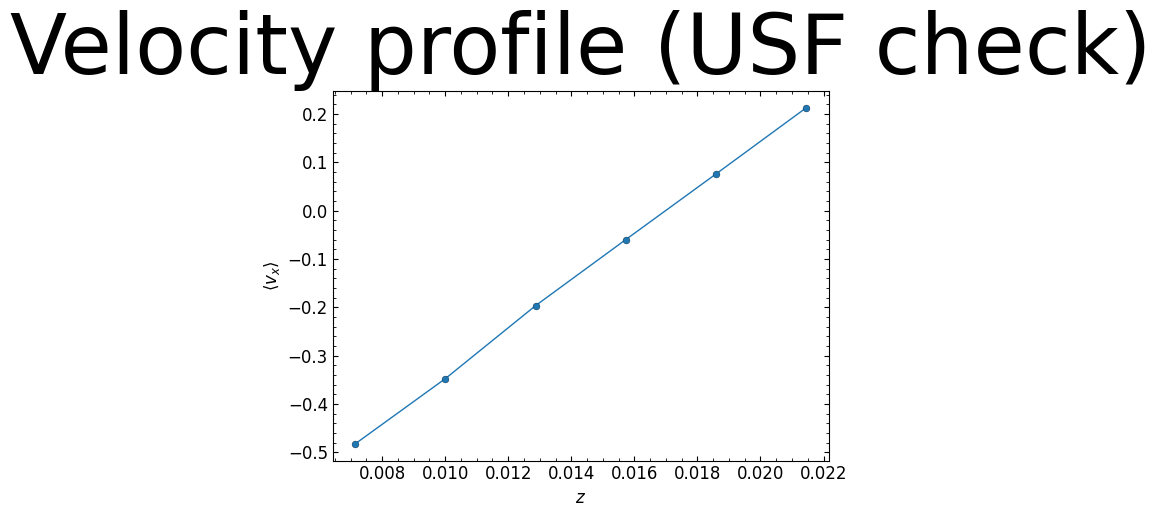

In [72]:
vxfile = os.path.join(folder_path, "/home/muhammed/Downloads/test_mfix/nu_001/60/vxprof.txt")

z, vx = load_vx_profile(vxfile, zlength=L, discard=2)

fig, ax = plt.subplots()
ax.plot(z, vx, "o-")

ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$\langle v_x \rangle$")
ax.set_title("Velocity profile (USF check)")

ax.tick_params(direction="in", which="both", top=True, right=True)
ax.minorticks_on()

plt.show()

In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

# ------------------------------------------------------------
# Formatting (reuse your existing style if already imported)
# ------------------------------------------------------------
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
formatter.set_powerlimits((-1, 1))

# ------------------------------------------------------------
# Physical parameters (must match simulation)
# ------------------------------------------------------------
L = 48
B = 48
sigma = 1
sol_frac = 0.01

n = (6.0 * sol_frac) / (np.pi * sigma**3)
volume = L**2 * B
density = n   # number density

def chi_ma(sol_frac):
    sol_frac_pack = 0.643
    C1, C2, C3, C_POW = 2.5, 4.5904, 4.515439, 0.67802
    if sol_frac > sol_frac_pack:
        return 1000.0
    numer = 1.0 + C1 * sol_frac + C2 * sol_frac**2 + C3 * sol_frac**3
    numer = numer * 4.0 * sol_frac
    denom = (1.0 - (sol_frac/sol_frac_pack)**3.0)**C_POW
    return min(1.0 + numer/denom, 1000.0)

chi_val = chi_ma(sol_frac)

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
base_dir = "/home/muhammed/Documents/Thesis/Shear_Simulation_Results/DEM/Validations/AR1"
alpha_dirs = ["AR10B"]

# ------------------------------------------------------------
# Storage
# ------------------------------------------------------------
alpha_vals = []
Pxx_vals = []
Pyy_vals = []
Pzz_vals = []
Pxy_vals = []

# ------------------------------------------------------------
# Loop over alpha folders
# ------------------------------------------------------------
for folder in alpha_dirs:
    folder_path = os.path.join(base_dir, folder)
    stress_file = os.path.join(folder_path, "stress.txt")
    T_file = os.path.join(folder_path, "T.txt")

    stress = np.loadtxt(stress_file)
    Tdata  = np.loadtxt(T_file)

    time = stress[:,0]
    Pxx = stress[:,1]
    Pxy = stress[:,2]
    Pyy = stress[:,5]
    Pzz = stress[:,9]

    Tg = Tdata[:,2]  # translational granular temperature

    # --- Steady averaging window ---
    # Take last 20% of samples (robust for DEM)
    N = len(time)
    i0 = int(0.6 * N)

    Pxx_m = np.mean(Pxx[i0:])
    Pyy_m = np.mean(Pyy[i0:])
    Pzz_m = np.mean(Pzz[i0:])
    Pxy_m = np.mean(Pxy[i0:])
    Tg_m  = np.mean(Tg[i0:])

    # Reduced stresses
    Pxx_star = Pxx_m / (density * Tg_m)
    Pyy_star = Pyy_m / (density * Tg_m)
    Pzz_star = Pzz_m / (density * Tg_m)
    Pxy_star = Pxy_m / (density * Tg_m)

    #alpha_vals.append(int(folder)/100)
    Pxx_vals.append(Pxx_star)
    Pyy_vals.append(Pyy_star)
    Pzz_vals.append(Pzz_star)
    Pxy_vals.append(Pxy_star)

# Convert to arrays
#alpha_vals = np.array(alpha_vals)
Pxx_vals = np.array(Pxx_vals)
Pyy_vals = np.array(Pyy_vals)
Pzz_vals = np.array(Pzz_vals)
Pxy_vals = np.array(Pxy_vals)

In [52]:
print(Pxx_vals)
print(Pyy_vals)
print(Pzz_vals)
print(Pxy_vals)

[3.62998076]
[2.12768085]
[2.14425668]
[-0.01010629]


In [53]:
vxfile = os.path.join(folder_path, "/home/muhammed/Documents/Thesis/Shear_Simulation_Results/DEM/Validations/AR1/AR10B/vxprof.txt")

z, vx = load_vx_profile(vxfile, zlength=L, discard=2)

fig, ax = plt.subplots()
ax.plot(z, vx, "o-")

ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$\langle v_x \rangle$")
ax.set_title("Velocity profile (USF check)")

ax.tick_params(direction="in", which="both", top=True, right=True)
ax.minorticks_on()

plt.show()

FileNotFoundError: /home/muhammed/Documents/Thesis/Shear_Simulation_Results/DEM/Validations/AR1/AR10B/vxprof.txt not found.

In [4]:
C1 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.20])
Z_AR25 = np.array([1.2431, 1.265, 1.297676, 1.3291, 1.3783, 1.4324, 1.49, 1.5585, 1.68435, 1.7322, 1.796604, 1.905176])
Z_AR2 = np.array([1.19798, 1.23276, 1.2355, 1.27945, 1.327697, 1.3789, 1.43978, 1.5055, 1.59329, 1.674, 1.74836, 1.849768])
Z_AR15 = np.array([0.885, 0.9379, 0.9836, 1.0425, 1.0975, 1.1573, 1.224, 1.278, 1.3687, 1.4332, 1.519, 1.5928])
C3 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
Z_AR3 = [1.273, 1.294, 1.34118, 1.355, 1.41528,1.455, 1.50995, 1.5774, 1.66304, 1.75116, 1.8276, 1.949]

def quadratic_model(C, a, b, c):
    return a * C**2 + b * C + c

a, b, c_AR2 = 0.3884, 0.0924, 1.1852
c_AR15 = 0.96  # Shift down for AR=1.5
c_AR25 = 1.235  # Shift up for AR=2.5
c_AR3 = 1.26  # Shift up for AR=2.5
C = np.linspace(0.05, 1.2, 100)
ZR_AR3 = quadratic_model(C, a, b, c_AR3)
ZR_AR25 = quadratic_model(C, a, b, c_AR25)
ZR_AR2 = quadratic_model(C, a, b, c_AR2)
ZR_AR15 = quadratic_model(C, a, b, c_AR15)

In [68]:
Z08 = quadratic_model(0.4, a, b, c_AR3)
Z08

1.359104

In [39]:
colors

['#0302FC', '#4101BD', '#80017F', '#BF0040', '#FE0002']

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import math
from matplotlib import ticker
from colormap import rgb2hex                         # keep if you prefer it
# NEW ────────────────────────────────────────────────────────────────────────
# axes_grid → axes_grid1   (same functionality, maintained sub-package)
from mpl_toolkits.axes_grid1.inset_locator import (
    inset_axes, InsetPosition, mark_inset
)
# ────────────────────────────────────────────────────────────────────────────

# --------------------------------------------------------------------------
# Matplotlib global style
# --------------------------------------------------------------------------
plt.rc("text", usetex=False)
plt.rc("font", size=12)
plt.rc("axes", titlesize=60)
plt.rcParams.update({
    "legend.fontsize": 12,
    "lines.markersize": 5,
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.2,
    "lines.linewidth": 1.0,
})

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))

# --------------------------------------------------------------------------
# Plot parameters
# --------------------------------------------------------------------------
aspect = 1.0

# Custom colour palette (red → blue gradient)
ncol = 5
red  = np.array([254,   0,   2], dtype=int)
blue = np.array([  3,   2, 252], dtype=int)

c1 = np.linspace(red[0],  blue[0],  ncol, dtype=int)
c2 = np.linspace(red[1],  blue[1],  ncol, dtype=int)
c3 = np.linspace(red[2],  blue[2],  ncol, dtype=int)

colors = [rgb2hex(r, g, b) for r, g, b in zip(c1, c2, c3)][::-1]

markers = ["o", "^", "v", "s", "D", "X", "*"]

In [53]:
colors

['#0302FC', '#4101BD', '#80017F', '#BF0040', '#FE0002']

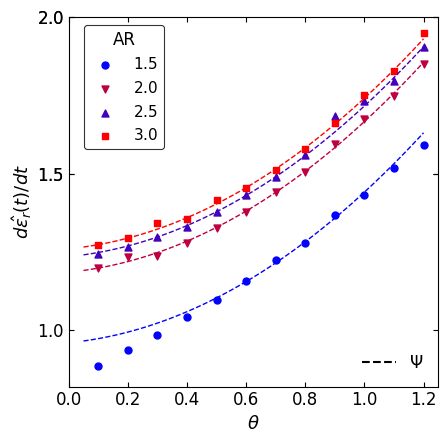

In [31]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots();
ax.yaxis.set_major_formatter(formatter)

ax.scatter(C1, Z_AR15, label=r'$1.5$', marker=markers[0], color=colors[0])
ax.scatter(C1, Z_AR2, label=r'$2.0$', marker=markers[2], color=colors[3])
ax.scatter(C1, Z_AR25, label=r'$2.5$', marker=markers[1], color=colors[1])
ax.scatter(C3, Z_AR3, label=r'$3.0$', marker=markers[3], color=colors[4])



ax.plot(C, ZR_AR15, '--',  color=colors[0])
ax.plot(C, ZR_AR2, '--',  color=colors[3])
ax.plot(C, ZR_AR25, '--',  color=colors[1])
ax.plot(C, ZR_AR3, '--',  color=colors[4])

ax.set_xlim([0,1.25])
ax.set_ylim([0.82,2.0])
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$d\hat{\varepsilon_r}(t)/dt$',labelpad=+2)
xval, yval = ax.get_xlim(), ax.get_ylim()
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')

ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)
#ax.minorticks_on()
legend1 = ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.15, 1.0),
    fontsize=11,
    frameon=True,
    title=r'AR'
)
legend1.get_frame().set_edgecolor('black')
legend1.get_frame().set_linewidth(0.8)
ax.add_artist(legend1)
#ax.xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticks([1.0, 1.5, 2.0, 1.5, 2.0])

from matplotlib.lines import Line2D
model_handle = Line2D([0], [0], color='black', lw=1.5, linestyle='--', label=r'$\Psi$')
ax.legend(handles=[model_handle], loc='lower right', frameon=False)

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.savefig('ZR.png',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


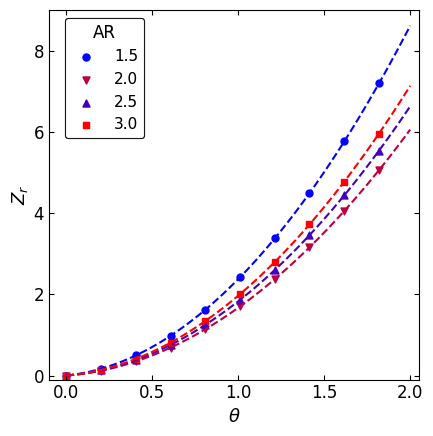

In [35]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots();
ax.yaxis.set_major_formatter(formatter)

# Range of theta (x)
x = np.linspace(0, 2, 100)

# Coefficients for each AR (b values)
b_values = [4.95, 3.48, 3.81, 4.10]
AR_values = [1.5, 2.0, 2.5, 3.0]
colors = [colors[0], colors[3], colors[1], colors[4]]
markers = [markers[0], markers[2], markers[1], markers[3]]
# Plot each curve
for b, ar, m, c in zip(b_values, AR_values, markers, colors):
    y = b * (0.39 * x**2 + 0.09 * x)
    plt.plot(x, y, '--', color=c, lw=1.5)
    plt.scatter(x[::10], y[::10], s=25, color=c, marker=m, label=f'{ar}')
    
ax.set_xlim([-0.1,2.05])
ax.set_ylim([-0.1,9])
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$Z_r$',labelpad=+2)
xval, yval = ax.get_xlim(), ax.get_ylim()
xrange = xval[1]-xval[0];
yrange = yval[1]-yval[0];
ax.set_aspect(aspect*(xrange/yrange), adjustable='box')

ax.tick_params(axis='both',direction='in',which='both',right=True,top=True)
#ax.minorticks_on()
legend1 = ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.15, 1.0),
    fontsize=11,
    frameon=True,
    title=r'AR'
)
legend1.get_frame().set_edgecolor('black')
legend1.get_frame().set_linewidth(0.8)
ax.add_artist(legend1)
ax.set_xticks([0, 0.5, 1, 1.5, 2])
#ax.set_yticks([0, 1.5, 2.0, 1.5, 2.0])

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.savefig('ZR_rot.eps',bbox_inches='tight')

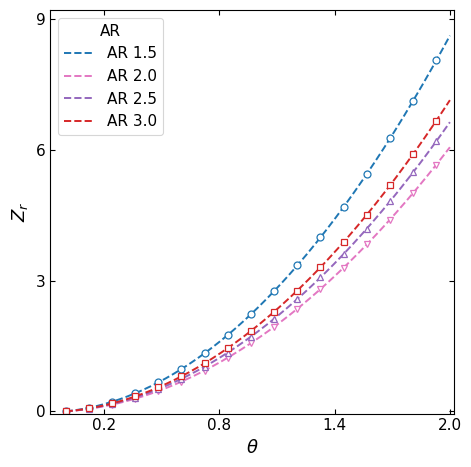

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# --------------------------
# Data / model
# --------------------------
theta = np.linspace(0, 2.0, 200)
AR_vals = [1.5, 2.0, 2.5, 3.0]
b_vals  = [4.95, 3.48, 3.81, 4.10]            # same order as AR_vals
colors  = ['tab:blue', 'tab:pink', 'tab:purple', 'tab:red']
markers = ['o', 'v', '^', 's']

def Zr(theta, b):
    return b * (0.39*theta**2 + 0.09*theta)

# --------------------------
# Matplotlib style
# --------------------------
plt.rcParams.update({
    "text.usetex": False,
    "font.size": 11,
    "axes.labelsize": 13,
    "legend.fontsize": 11,
    "lines.linewidth": 1.4,
})

fig,ax = plt.subplots();   # ~single-column friendly

# --------------------------
# Plot
# --------------------------
for ar, b, c, m in zip(AR_vals, b_vals, colors, markers):
    y = Zr(theta, b)
    ax.plot(theta, y, ls='--', c=c, label=fr'AR {ar}')
    # sparse markers for readability
    ax.plot(theta[::12], y[::12], linestyle='None',
            marker=m, ms=5.0, mfc='white', mec=c, mew=0.9)

# --------------------------
# Axes formatting
# --------------------------
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$Z_r$')

# limits with a touch of breathing room
ax.set_xlim(-0.08, 2.02)
ax.set_ylim(-0.05, 9.2)

# sparse, clean ticks
ax.xaxis.set_major_locator(FixedLocator([0.2, 0.8, 1.4, 2.0]))
ax.yaxis.set_major_locator(FixedLocator([0, 3, 6, 9]))

# inward ticks on all sides
ax.tick_params(direction='in', which='both', top=True, right=True)

# equal visual aspect (nice geometry)
x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
ax.set_aspect((x1 - x0) / (y1 - y0))  # aspect ~ 1 in data units

# legend box
leg = ax.legend(title='AR', frameon=True, loc='upper left')
leg.get_frame().set_linewidth(0.8)

plt.tight_layout()

# Save (uncomment what you need)
# plt.savefig('Zr_vs_theta.pdf', dpi=400, bbox_inches='tight')
# plt.savefig('Zr_vs_theta.eps', bbox_inches='tight')
plt.show()


In [50]:
# Chi function (Ma and Ahmadi)
def chi_ma(sol_frac):
    sol_frac_pack = 0.643
    C1, C2, C3, C_POW = 2.5, 4.5904, 4.515439, 0.67802
    if sol_frac > sol_frac_pack:
        return 1000.0
    numer = 1.0 + C1 * sol_frac + C2 * sol_frac**2 + C3 * sol_frac**3
    numer = numer * 4.0 * sol_frac
    denom = (1.0 - (sol_frac/sol_frac_pack)**3.0)**C_POW
    chi = 1.0 + numer/denom
    return min(chi, 1000.0)

def chi_Carnahan_Starling(solfrac):
    return (1 - solfrac/2)/((1-solfrac)**3)

L = 0.1
sigma = 0.01
sol_frac = 0.01
n = (6.0 * sol_frac) / (np.pi * sigma**3)

chi_val = chi_Carnahan_Starling(sol_frac)
lambda_mfp = 1.0 / (np.sqrt(2.0) * np.pi * n * sigma**2 * chi_val)

DSMC_L = (L/lambda_mfp)*20
DSMC_L

17.40258408463242

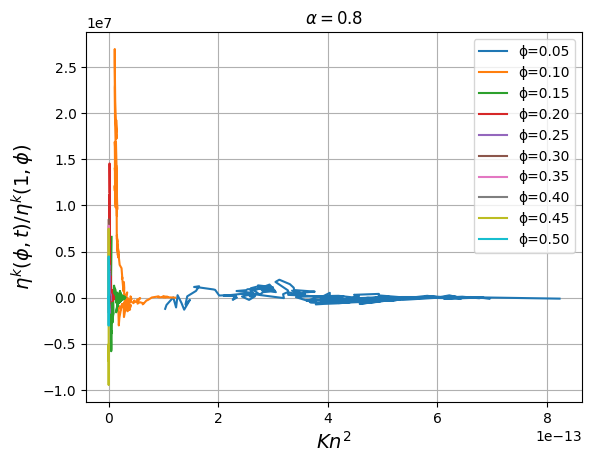

In [51]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Constants
sigma = 0.01         
rho = 2500
PIP = 100000
Volume = 0.1*0.1*0.1
pvol = (1/6)*(np.pi)*(sigma**3)
pmass = pvol*rho         
shear_rate = 1e-3   

# Chi function (Ma and Ahmadi)
def chi_ma(sol_frac):
    sol_frac_pack = 0.643
    C1, C2, C3, C_POW = 2.5, 4.5904, 4.515439, 0.67802
    if sol_frac > sol_frac_pack:
        return 1000.0
    numer = 1.0 + C1 * sol_frac + C2 * sol_frac**2 + C3 * sol_frac**3
    numer = numer * 4.0 * sol_frac
    denom = (1.0 - (sol_frac/sol_frac_pack)**3.0)**C_POW
    chi = 1.0 + numer/denom
    return min(chi, 1000.0)

# --- Base Directory ---
base_dir = '/home/muhammed/Documents/Thesis/Shear_Simulation_Results/Run_shear_Gauss_Stoch2/alpha_80'

# --- Solids fraction folders ---
sol_frac_folders = ['005', '010', '015', '020', '025', '030', '035', '040', '045', '050']

for folder in sol_frac_folders:
    sol_frac = int(folder) / 100.0    # e.g., '005' -> 0.005
    F_N = (sol_frac * Volume) / (pvol*PIP)  # number fraction density
    chi_val = chi_ma(sol_frac)
    n = (6.0 * sol_frac) / (np.pi * sigma**3)
    lambda_mfp = 1.0 / (np.sqrt(2.0) * np.pi * n * sigma**2 * chi_val)

    folder_path = os.path.join(base_dir, folder)

    try:
        tg = np.loadtxt(os.path.join(folder_path, 'tg.txt'))[:,2]   # Assuming: time, other, Tg
        pijk = loadtxt_fortran(os.path.join(folder_path, 'Pijk.txt'))
        pijc = loadtxt_fortran(os.path.join(folder_path, 'Pijc.txt'))

        steps = np.arange(len(tg))
        Kn_t = (lambda_mfp * shear_rate) / np.sqrt(2.0 * tg[1:] / pmass)
        Kn2_t = Kn_t**2

        # --- Compute Total Stress Tensor ---
        Pxy = (pijk[1:,3] + pijc[:,1])    # [pijk(1,2) + pijc(1,2)]

        eta_total = -Pxy / shear_rate
        eta_kinetic = -pijk[1:,3] / shear_rate

        eta0 = (5.0/16.0) * np.sqrt(pmass * tg[0]/np.pi) / (np.pi * sigma**2)

        eta_k_norm = eta_kinetic / eta0

        plt.plot(Kn2_t, eta_k_norm, label=f'ϕ={sol_frac:.2f}')

    except Exception as e:
        print(f"Skipped folder {folder_path} due to error: {e}")

plt.xlabel(r'$Kn^2$', fontsize=14)
plt.ylabel(r'$\eta^k(\phi, t)/\eta^k(1, \phi)$', fontsize=14)
plt.title(r'$\alpha=0.8$')
plt.legend()
#plt.xlim(0, 0.01)
plt.grid()
plt.show()